### 3.3.1 - Deep Neural Network (DNN) model

In [1]:
# Load the packages and other tools
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import shap
shap.initjs()
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from scipy import stats
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from scalecast.Forecaster import Forecaster
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import KalmanSmoother

C:\Users\sofia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\sofia\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


#### Specific pre-processing to DL

In [45]:
# load data
model1 = pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/model/model.xlsx',index_col=0)

* Data Preparation

In [46]:
# Removing multicollinearity by dropping one of the variables in the pair
model1= model1.drop(['lg_Open','lg_Low','block-size'],axis=1)

In [56]:
# Creating the variables
for i in range(len(model1)+1):
    for j in range(0,26): 
        model1[str(model1.columns[j]+'_t-1')]=''
        model1[str(model1.columns[j]+'_t-2')]=''

In [69]:
# Filling with the respective values
for i in range(len(model1)):
    for j in range(0,26): 
        if i==0:
            model1[str(model1.columns[j]+'_t-1')][i]=model1[str(model1.columns[j])][i]
            model1[str(model1.columns[j]+'_t-2')][i]=model1[str(model1.columns[j])][i]
        if i==1:
            model1[str(model1.columns[j]+'_t-1')][i]=model1[str(model1.columns[j])][i-1]
            model1[str(model1.columns[j]+'_t-2')][i]=model1[str(model1.columns[j])][i-1]
        else: 
            model1[str(model1.columns[j]+'_t-1')][i]=model1[str(model1.columns[j])][i-1]
            model1[str(model1.columns[j]+'_t-2')][i]=model1[str(model1.columns[j])][i-2]

In [68]:
model1['lg_price'][0]

6.92108602839078

In [70]:
model1.head(2)

,lg_price,lg_market-cap,lg_trade-volume,lg_transaction-fees-usd,lg_avg-confirmation-time,lg_difficulty,lg_High,lg_hash-rate,lg_miners-revenue,n-transactions-total,...,GT_cryptocurrency_t-1,GT_cryptocurrency_t-2,GT_scam_t-1,GT_scam_t-2,lg_SP500_t-1,lg_SP500_t-2,lg_Oil_t-1,lg_Oil_t-2,Theft_t-1,Theft_t-2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6.921086,23.527405,15.376856,11.651582,2.566197,1.94591,6.921086,14.767149,14.575693,183961799.0,...,26,26,3,3,8.351962,8.351962,4.244487,4.244487,0,0
2017-01-02,6.921086,23.527405,15.376856,11.651582,4.578962,1.94591,6.938963,14.767149,14.575693,183961799.0,...,2,2,1,1,7.729786,7.729786,3.961004,3.961004,1,1


In [71]:
#model1.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/DNN/DNN.xlsx')

In [2]:
dl=pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/DNN/DNN.xlsx',index_col=0)

In [48]:
dl.head(2)

,lg_price,lg_market-cap,lg_trade-volume,lg_transaction-fees-usd,lg_avg-confirmation-time,lg_difficulty,lg_High,lg_hash-rate,lg_miners-revenue,n-transactions-total,...,GT_cryptocurrency_t-1,GT_cryptocurrency_t-2,GT_scam_t-1,GT_scam_t-2,lg_SP500_t-1,lg_SP500_t-2,lg_Oil_t-1,lg_Oil_t-2,Theft_t-1,Theft_t-2
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,6.921086,23.527405,15.376856,11.651582,2.566197,1.94591,6.921086,14.767149,14.575693,183961799.0,...,26,26,3,3,8.351962,8.351962,4.244487,4.244487,0,0
2017-01-02,6.921086,23.527405,15.376856,11.651582,4.578962,1.94591,6.938963,14.767149,14.575693,183961799.0,...,2,2,1,1,7.729786,7.729786,3.961004,3.961004,1,1


* Noise smoothing with tsmoothie library

In [3]:
# Splitting 80% for training and 20% for testing
train = dl[:-323]
test = dl[-323:]
test=test.drop(['lg_price'], axis=1)


# Splitting 80% for training and 20% for validation
train = train[:-65]
len(train)
val = train[-65:]
len(test)

# prepare x_train, y_train
x_train = train.drop(['lg_price'], axis=1).values
y_train = train['lg_price'].values

# scaling
scale = MinMaxScaler(feature_range=(0,1))
x_train = scale.fit_transform(x_train)

# prepare x_test
x_test = test.values

# scaling
x_test = scale.transform(x_test)


# prepare x_val, y_val
x_val = val.drop(['lg_price'], axis=1).values
y_val = val['lg_price'].values

# scaling
from sklearn.preprocessing import MinMaxScaler
x_val = scale.fit_transform(x_val)

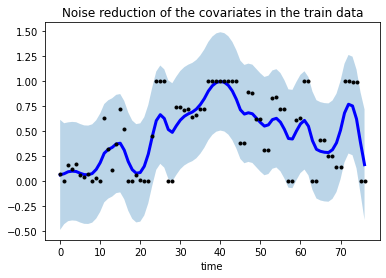

In [4]:
# operate smoothing
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.1, 'trend':0.1})
smoother.smooth(x_train)

# generate intervals
low, up = smoother.get_intervals('kalman_interval')

# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')
plt.title('Noise reduction of the covariates in the train data')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/smoother_x_train.jpeg')

In [5]:
# Applying the smoother to x_train
x_train= smoother.smooth_data

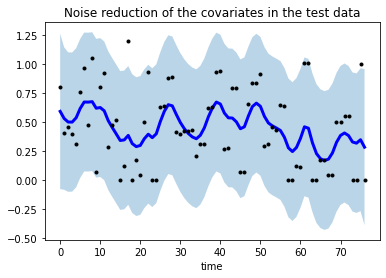

In [6]:
# operate smoothing
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.1, 'trend':0.1})
x_test=smoother.smooth(x_test)

# generate intervals
low, up = smoother.get_intervals('kalman_interval')

# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')
plt.title('Noise reduction of the covariates in the test data')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
x_test= smoother.smooth_data
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/smoother_x_test.jpeg')

In [7]:
# Applying the smoother to x_test
x_test= smoother.smooth_data

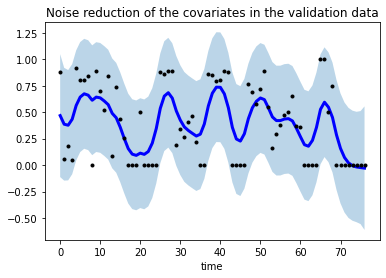

In [8]:
# operate smoothing
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.1, 'trend':0.1})
x_val=smoother.smooth(x_val)

# generate intervals
low, up = smoother.get_intervals('kalman_interval')

# plot the first smoothed timeseries with intervals
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.xlabel('time')
plt.title('Noise reduction of the covariates in the validation data')

plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
x_val= smoother.smooth_data
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/smoother_x_val.jpeg')

In [9]:
# Applying the smoother to x_val
x_val= smoother.smooth_data

* Keras Hypertuning - Grid Search

In [92]:
def get_model(param):
        
    model = Sequential()
    model.add(Dense(param['unit_1'], activation=param['activ']))
    model.add(Dense(param['unit_2'], activation=param['activ']))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=param['lr']), 
                  loss='mse', metrics=['mse'])
    
    return model

In [93]:
from tensorflow.keras.optimizers import Adam
from kerashypetune import KerasGridSearch
param_grid = {
    'unit_1': [128,64], 
    'unit_2': [64,32],
    'lr': [1e-2,1e-3], 
    'activ': ['elu','relu'],
    'epochs': 100, 
    'batch_size': 512
}

kgs = KerasGridSearch(get_model, param_grid, monitor='val_loss', greater_is_better=False)
kgs.search(x_train, y_train, validation_data=(x_val, y_val))


16 trials detected for ('unit_1', 'unit_2', 'lr', 'activ', 'epochs', 'batch_size')

***** (1/16) *****
Search({'unit_1': 128, 'unit_2': 64, 'lr': 0.01, 'activ': 'elu', 'epochs': 100, 'batch_size': 512})
SCORE: 0.27756 at epoch 21

***** (2/16) *****
Search({'unit_1': 128, 'unit_2': 64, 'lr': 0.01, 'activ': 'relu', 'epochs': 100, 'batch_size': 512})
SCORE: 1.68134 at epoch 23

***** (3/16) *****
Search({'unit_1': 128, 'unit_2': 64, 'lr': 0.001, 'activ': 'elu', 'epochs': 100, 'batch_size': 512})
SCORE: 0.39192 at epoch 96

***** (4/16) *****
Search({'unit_1': 128, 'unit_2': 64, 'lr': 0.001, 'activ': 'relu', 'epochs': 100, 'batch_size': 512})
SCORE: 1.77961 at epoch 46

***** (5/16) *****
Search({'unit_1': 128, 'unit_2': 32, 'lr': 0.01, 'activ': 'elu', 'epochs': 100, 'batch_size': 512})
SCORE: 0.23834 at epoch 25

***** (6/16) *****
Search({'unit_1': 128, 'unit_2': 32, 'lr': 0.01, 'activ': 'relu', 'epochs': 100, 'batch_size': 512})
SCORE: 1.65859 at epoch 19

***** (7/16) *****
Search({'

In [94]:
kgs.scores

[0.27756,
 1.68134,
 0.39192,
 1.77961,
 0.23834,
 1.65859,
 0.69823,
 1.97753,
 0.28902,
 1.62592,
 0.4529,
 2.28285,
 0.27988,
 1.4463,
 0.52879,
 1.72776]

In [100]:
kgs.best_score

0.23834

In [ ]:
best_model=kgs.best_model
best_model

In [74]:
#best_model.save('best_model')

In [11]:
from keras.models import load_model
best_model= load_model('best_model')

In [12]:
# Predicting the values for lg_price
pred = best_model.predict(x_test)
print(pred[:5]) # Printing lg_price for the next 5 day to check if the values make sense
pred.shape

[[9.155369 ]
 [9.195578 ]
 [9.1616335]
 [9.121709 ]
 [9.08273  ]]


(323, 1)

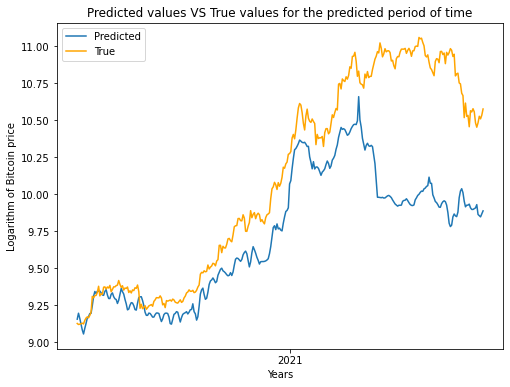

In [16]:
# Plotting the Predicted Bitcin price VS True Bitcoin price for the predicted period of time
original_test=dl.iloc[-323:,0]
date = original_test.index
fig, ax = plt.subplots(figsize=(8, 6))
year_locator = mdates.YearLocator()
ax.xaxis.set_major_locator(year_locator) # Locator for major axis only.
plt.plot(date, pred)
plt.plot(date, original_test,color='orange')
plt.title('Predicted values VS True values for the predicted period of time')
plt.xlabel('Years')
plt.ylabel('Logarithm of Bitcoin price')
plt.legend(['Predicted', 'True'])
plt.savefig('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/Figuras/DL_originalVSpred.jpeg')
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error
actual_price = dl[-323:]['lg_price'].values

# 1. MSE - Mean Squared Error
MSE= mean_squared_error(actual_price,pred)
print("Mean Square Error: ", MSE)

# 2. RMSE - Root Mean Square Error
RMSE = math.sqrt(MSE)
print("Root Mean Square Error: ", RMSE)

# 3. sMAPE - symmetric Mean Absolute Percentage Error
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))
sMAPE=smape(actual_price,pred)
print('sMAPE: ',sMAPE)

# 4. R^2 score
r2_score = metrics.r2_score(actual_price,pred)
print('R^2 score: ',r2_score)

Mean Square Error:  0.26367841455607127
Root Mean Square Error:  0.5134962653769463
sMAPE:  23.335936952688108
R^2 score:  0.41332585870436145


In [14]:
metric=pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx',index_col=0)
metric.head(3)

,Model,MSE,RMSE,sMAPE,R^2 score
0,GLS,0.016803,0.129628,0.009797,0.962613
1,LSTM,0.028533,0.168918,24.519984,0.936515


In [15]:
# Defining a dictionary
d = {'Model': 'DNN','MSE': MSE,'RMSE':RMSE,'sMAPE':sMAPE,'R^2 score': r2_score}

# Adding the most recent results to the existing dataframe
metric = metric.append(d, ignore_index=True)
metric.to_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx')

In [116]:
metric=pd.read_excel('C:/Users/sofia/OneDrive/Desktop/CLSBE/2nd year/Tese/data/metrics/metrics.xlsx',index_col=1)
metric=metric.drop(['Unnamed: 0'],axis=1)
metric.head(3)

,MSE,RMSE,sMAPE,R^2 score
Model,,,,
GLS,0.016803,0.129628,0.009797,0.962613
LSTM,0.028533,0.168918,24.519984,0.936515
DNN,0.158891,0.398611,23.233846,0.646475
